# Deskripsi Proyek

Film Junky Union, sebuah komunitas baru bagi penggemar film klasik sedang mengembangkan sistem untuk memfilter dan mengategorikan ulasan film. Misi utamanya adalah melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Anda akan menggunakan dataset ulasan film IMBD dengan pelabelan polaritas untuk membuat sebuah model yang bisa mengklasifikasikan ulasan positif dan negatif. Model ini setidaknya harus memiliki skor F1 sebesar 0,85.

# Instruksi Proyek
- Muat datanya.
- Lakukan pra-pemrosesan data apabila memang diperlukan.
- Lakukan EDA dan buat kesimpulan terkait ketidakseimbangan kelas.
- Lakukan pra-pemrosesan data untuk membuat model.
- Latih setidaknya tiga model untuk train dataset yang ada.
- Uji model untuk test dataset yang ada.
- Tulis beberapa ulasan Anda sendiri dan klasifikasikan dengan semua model.
- Periksa perbedaan antara hasil pengujian model dari dua poin di atas. Cobalah untuk menjelaskan hasilnya.
- Tampilkan hasil penemuan Anda.

## Inisialisasi

In [1]:
import math
import re
import nltk
import spacy
from PIL import Image

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

# import stopword
! pip3 install wordcloud
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

# import train_test_split untuk membagi data
from sklearn.model_selection import train_test_split

# import library dari metrics
from sklearn import metrics
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score,
                             balanced_accuracy_score, roc_auc_score, roc_curve)

import sys
import warnings 
warnings.filterwarnings("ignore")

     |████████████████████████████████| 460 kB 14.9 MB/s eta 0:00:01


In [2]:
# Time Progress 

!pip install ipython-autotime

%load_ext autotime

time: 373 µs (started: 2023-08-06 16:21:20 +00:00)


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# baris berikutnya menyediakan grafik dengan kualitas yang lebih baik di layar HiDPI 
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

time: 22.1 ms (started: 2023-08-06 16:21:20 +00:00)


In [4]:
# ini untuk menggunakan progress_apply, baca lebih lanjut di https://pypi.org/project/tqdm/# pandas-integration
tqdm.pandas()

time: 2.35 ms (started: 2023-08-06 16:21:20 +00:00)


## Memuat data

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

time: 1.09 s (started: 2023-08-06 16:21:20 +00:00)


In [6]:
# Membuat Fungsi untuk menentukan jika ada columns yang memiliki nilai yang hilang
def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} dengan {:.{}%} persentasi nilai yang hilang , dan {} nilai yang hilang'.format(column, percent, num, num_of_nulls))
    if count != 0:
        print("\033[1m" + 'Terdapat {} columns dengan nilai NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'Tidak Terdapat columns dengan nilai NA.' + "\033[0m")

# Fungsi untuk melihat informasi keseluruhan pada dataset
def get_info(df):
    print("\033[1m" + '-'*100 + "\033[0m")
    print('Head:')
    print()
    display(df.head(50))
    print('-'*100)
    print('Info:')
    print()
    display(df.info())
    print('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print('-'*100)
    display(df.describe(include='object'))
    print()
    print('Columns dengan nilai yang hilang:')
    display(get_percent_of_na(df, 4))
    print('-'*100)
    print('Shape:')
    print(df.shape)
    print('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'Kita mempunyai {} baris yang terduplikasi.\n'.format(df.duplicated().sum()) + "\033[0m")
    print()

time: 3.51 ms (started: 2023-08-06 16:21:21 +00:00)


In [7]:
get_info(df_reviews)

----------------------------------------------------------------------------------------------------
Head:



,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 

None

----------------------------------------------------------------------------------------------------
Describe:



,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


----------------------------------------------------------------------------------------------------


,tconst,title_type,primary_title,original_title,end_year,runtime_minutes,genres,review,sp,ds_part
count,47331,47331,47331,47331,47331,47331,47331,47331,47331,47331
unique,6648,10,6555,6562,60,249,585,47240,2,2
top,tt0116130,movie,The Sentinel,The Sentinel,\N,90,Drama,Loved today's show!!! It was a variety and not...,neg,train
freq,30,36861,60,60,45052,2442,3392,5,23715,23796



Columns dengan nilai yang hilang:
Column average_rating dengan 0.0042% persentasi nilai yang hilang , dan 2 nilai yang hilang
Column votes dengan 0.0042% persentasi nilai yang hilang , dan 2 nilai yang hilang
Terdapat 2 columns dengan nilai NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(47331, 17)
----------------------------------------------------------------------------------------------------
Duplicated:
Kita mempunyai 0 baris yang terduplikasi.


time: 732 ms (started: 2023-08-06 16:21:21 +00:00)


## EDA

Memeriksa jumlah film dan ulasan selama beberapa tahun.

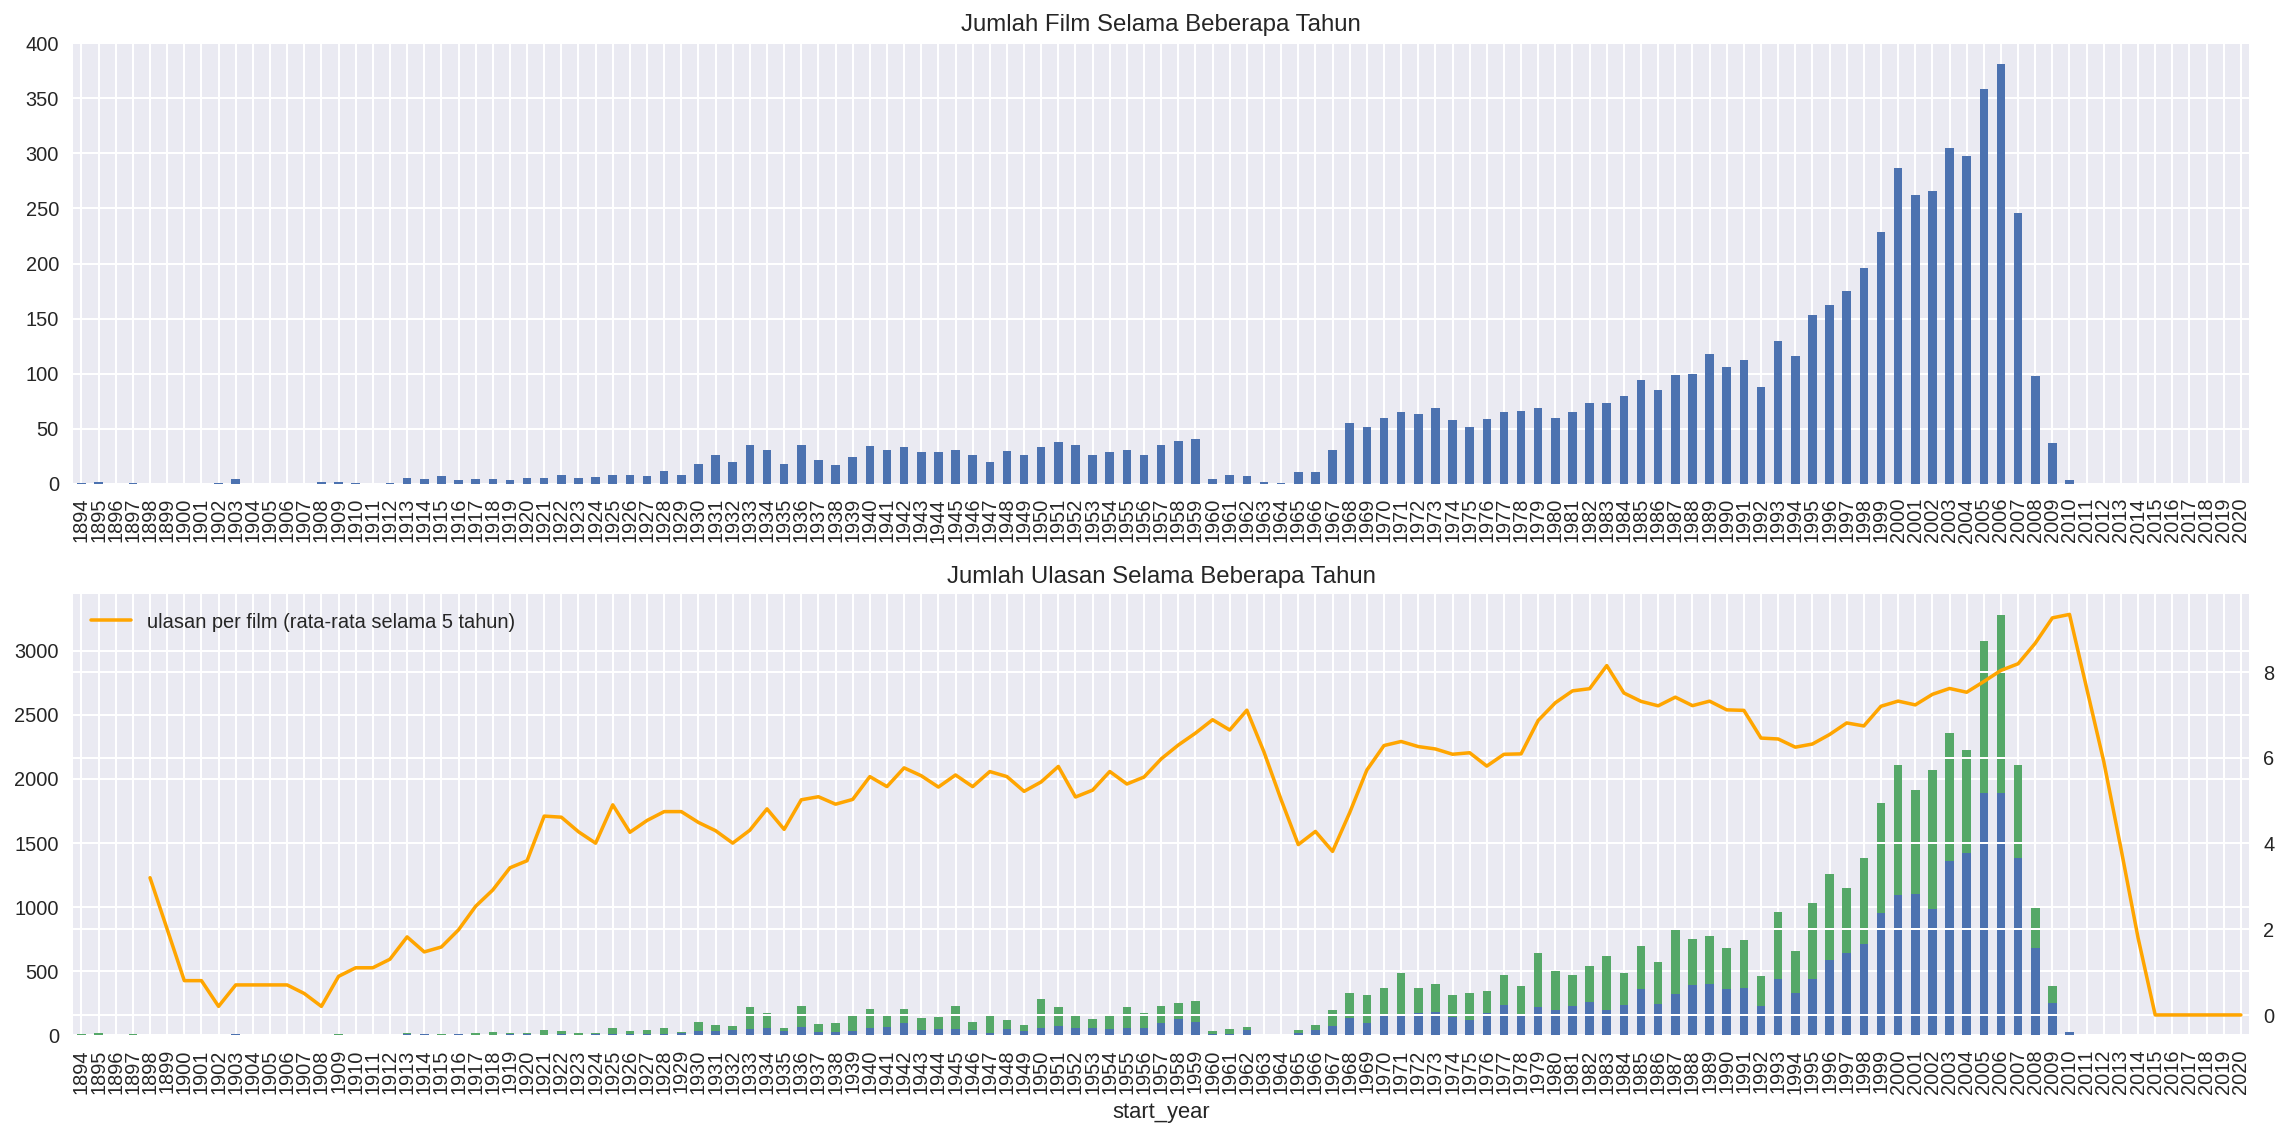

time: 5.6 s (started: 2023-08-06 16:21:22 +00:00)


In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun') 

fig.tight_layout()

Memeriksa distribusi jumlah ulasan per film dengan penghitungan yang tepat dan KDE (hanya untuk mengetahui perbedaannya dari penghitungan yang tepat)

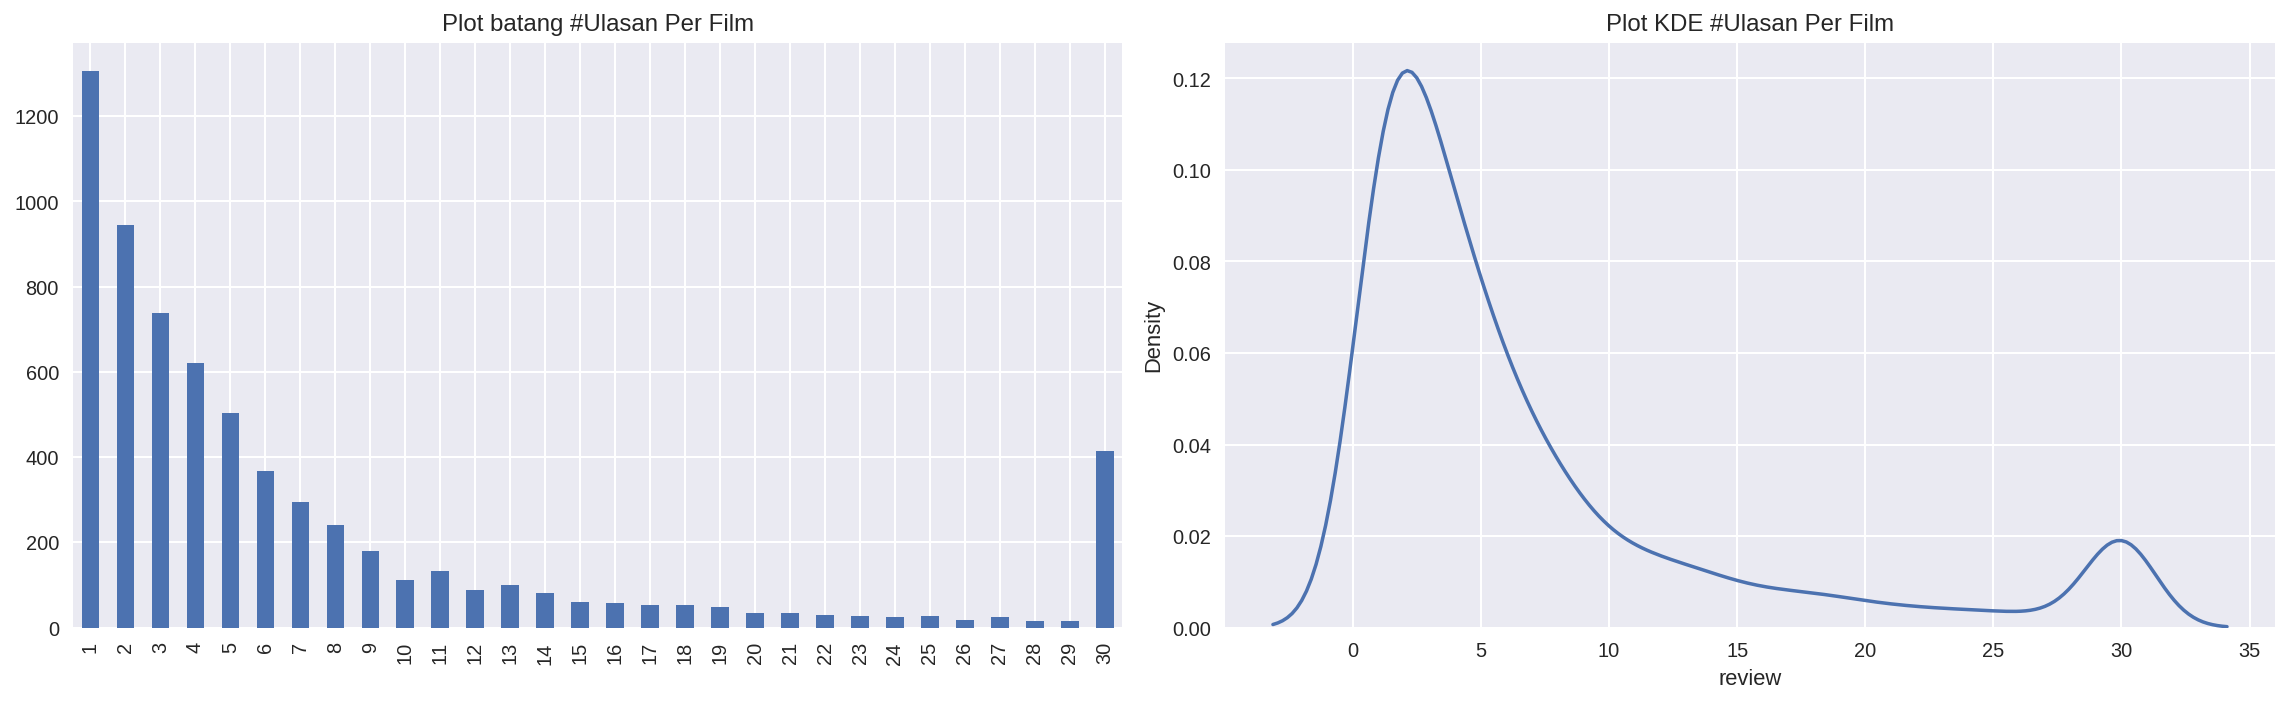

time: 1.18 s (started: 2023-08-06 16:21:27 +00:00)


In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film') 

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film') 

fig.tight_layout()

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

time: 4.86 ms (started: 2023-08-06 16:21:29 +00:00)


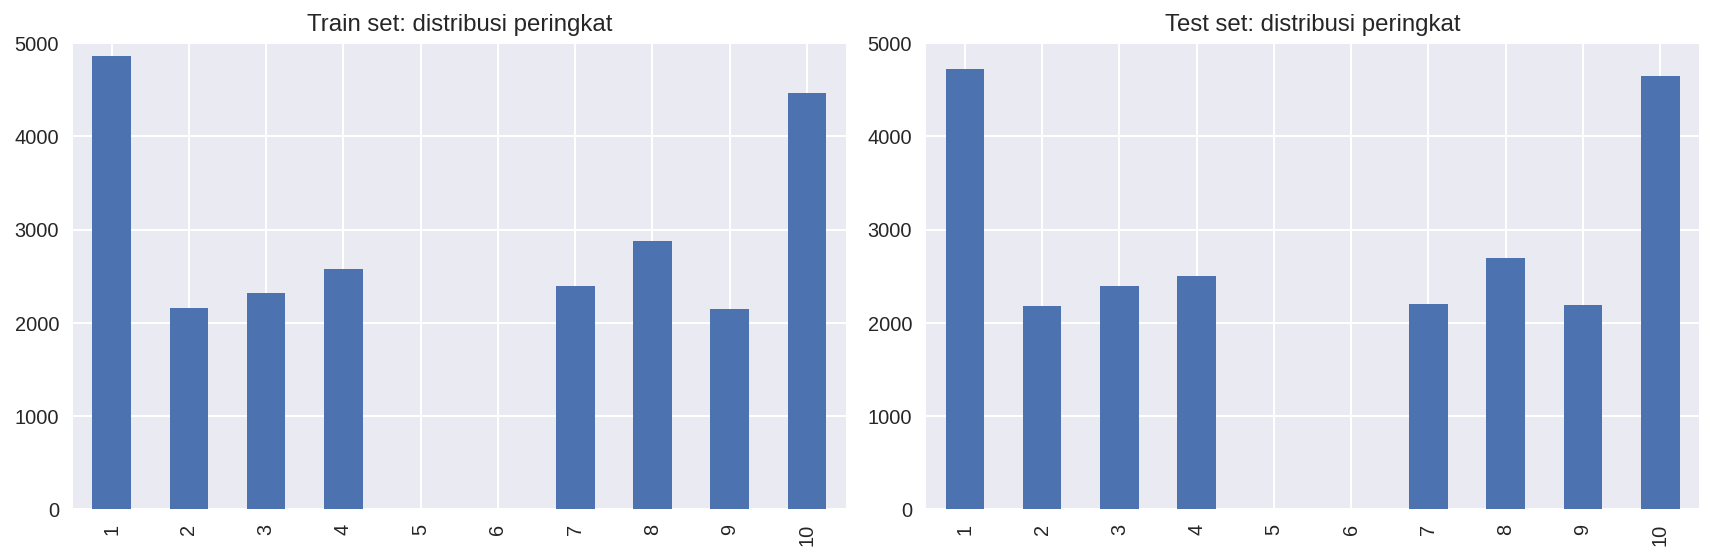

time: 629 ms (started: 2023-08-06 16:21:29 +00:00)


In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: distribusi peringkat')

fig.tight_layout()

Plot Distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian *dataset*

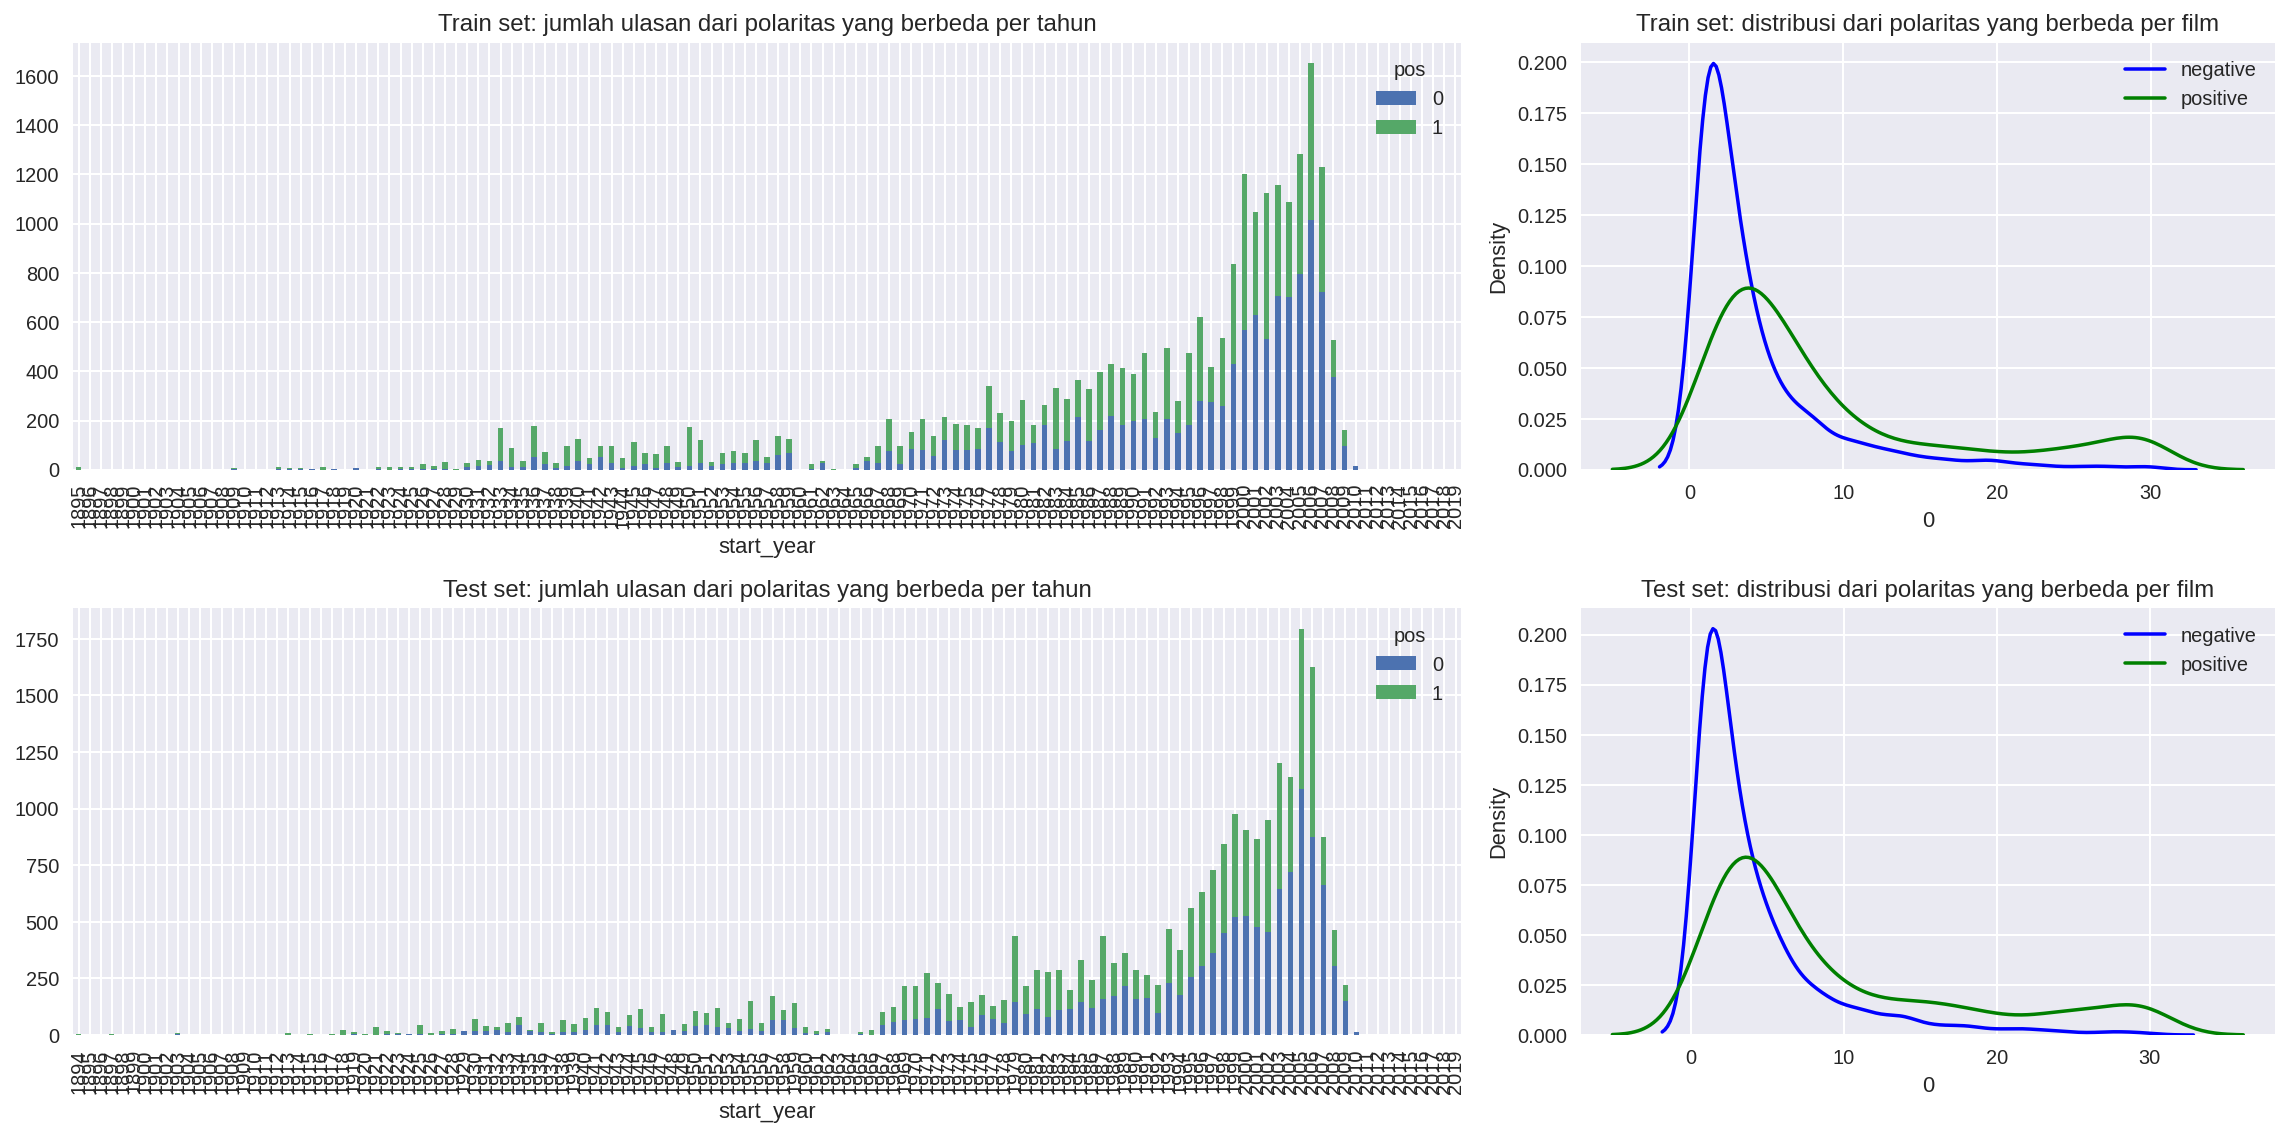

time: 6.57 s (started: 2023-08-06 16:21:29 +00:00)


In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Train set: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Test set: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

## Prosedur Evaluasi

Menyusun evaluasi yang dapat digunakan untuk semua model dalam tugas ini secara rutin

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

time: 3.94 ms (started: 2023-08-06 16:21:36 +00:00)


## Normalisasi

Kita akan membuat fungsi untuk menormalisasi data dari text yang berfifat tidak standar seperti angka, tanda baca, dll.

In [14]:
# fungsi untuk clean the data
def clean_data(data):
    ''' 
    fungsi ini digunakan untuk membersihkan
    data karakter non standar
    '''
    clean_data = re.sub(r"[^a-zA-Z']", " ", data)
    clean_data = " ".join(clean_data.split())
    return clean_data.lower()

time: 1.23 ms (started: 2023-08-06 16:21:36 +00:00)


In [15]:
df_reviews['review_norm'] = df_reviews['review'].apply(clean_data)
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47331, dtype: object

time: 4.76 s (started: 2023-08-06 16:21:36 +00:00)


## Pemisahan Train / Test

Memisahkan seluruh *dataset* menjadi *train/test*. dimana kolom parameternya adalah 'ds_part'.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)
time: 56.5 ms (started: 2023-08-06 16:21:41 +00:00)


In [17]:
y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']


time: 2.48 ms (started: 2023-08-06 16:21:41 +00:00)


## Bekerja dengan Model

### Model 1 - Menggunakan NLTK & TF-IDF 

Pada tahap ini kita akan mendefenisikan Term Frequency — Inverse Document Frequency untuk di mengkonversi data teks menjadi vector, tetapi sebelumnya kita akan melakukan proses lemmatization pada feature dimana proses ini membantu mempermudah penanganan teks karena variasi bentuk kata yang tersedia menjadi lebih sedikit.

In [18]:
import nltk

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

time: 607 µs (started: 2023-08-06 16:21:41 +00:00)


In [19]:
# fungsi membuat token dan lemmatiz text 
def lemmatize_nltk(text):
    lemmatizer  = WordNetLemmatizer() # membuat lemmatiz pada data object
    tokens = word_tokenize(text.lower()) # memisahkan text kedalam tokens
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    lemmatized = " ".join(lemmas) 
    return lemmatized

time: 782 µs (started: 2023-08-06 16:21:41 +00:00)


In [20]:
# text pre-processing dengan NLTK
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 

time: 34.2 ms (started: 2023-08-06 16:21:41 +00:00)


####  Menjalankan fungsi token dan lemmatiz  pda train & test sampel

In [21]:
# menjalankan fungsi token dan lemmatiz  pda train & test sampel
df_reviews_train['review_nltk'] = X_train.apply(lemmatize_nltk)
df_reviews_test['review_nltk'] = X_test.apply(lemmatize_nltk)

# menjalankan TF-IDF pada train & test sampel
nltk_X_train = count_tf_idf.fit_transform(df_reviews_train['review_nltk'])
nltk_X_test = count_tf_idf.transform(df_reviews_test['review_nltk'])

time: 2min 8s (started: 2023-08-06 16:21:41 +00:00)


#### Data Frame hasil Model dengan TF IDF & NLTK

In [22]:
# Data Frame hasil Model dengan TF IDF & NLTK 
log_metrics_tf_idf = {"Models": ["Logistic Regression Classifier", "Gaussian Naive Bayes", "LightGBM Classifier" ,"Stochastic Gradient Classifier" ], "Accuracy_score": [0.0]*4, "F1 Score": [0.0]*4}
m_idx_tf_idf = {"Logistic Regression Classifier":0, "Gaussian Naive Bayes":1, "LightGBM Classifier":2, "Stochastic Gradient Classifier" :3}

time: 727 µs (started: 2023-08-06 16:23:50 +00:00)


#### Logistic Regression Classifier

In [23]:
from sklearn.linear_model import LogisticRegression

time: 1.01 ms (started: 2023-08-06 16:23:50 +00:00)


In [24]:
%%time

lr = LogisticRegression(random_state=12345, solver='liblinear')
lr.fit(nltk_X_train, y_train)
lr_tf_idf_pred = lr.predict(nltk_X_test)

CPU times: user 770 ms, sys: 1.41 s, total: 2.18 s
Wall time: 2.18 s
time: 2.19 s (started: 2023-08-06 16:23:50 +00:00)


In [25]:
acc_lr = accuracy_score(y_test, lr_tf_idf_pred)
f1_sc_lr  = f1_score(y_test, lr_tf_idf_pred)

log_metrics_tf_idf["Accuracy_score"][m_idx_tf_idf["Logistic Regression Classifier"]] = acc_lr
log_metrics_tf_idf["F1 Score"][m_idx_tf_idf["Logistic Regression Classifier"]] = f1_sc_lr

time: 14.9 ms (started: 2023-08-06 16:23:52 +00:00)


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


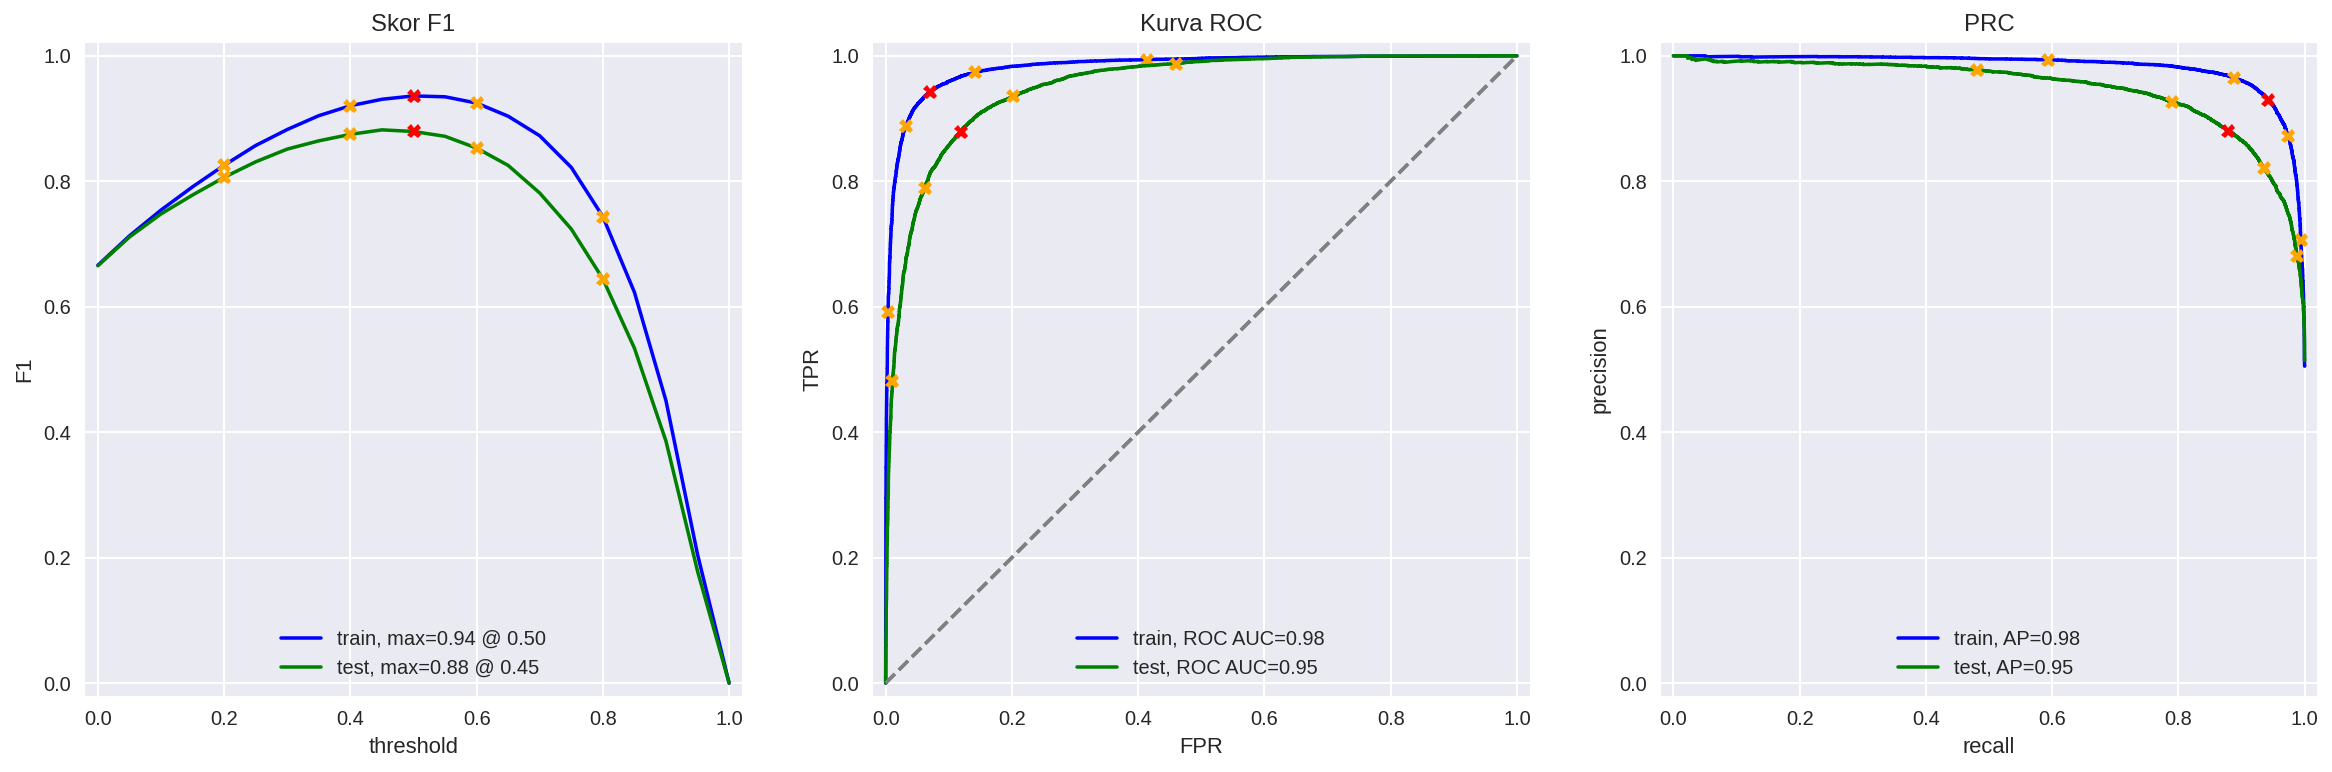

time: 1.28 s (started: 2023-08-06 16:23:52 +00:00)


In [26]:
evaluate_model(lr, nltk_X_train, y_train, nltk_X_test, y_test)

#### Gusion naïve Bayes Classifier 

In [27]:
from sklearn.naive_bayes import MultinomialNB

time: 3.88 ms (started: 2023-08-06 16:23:53 +00:00)


In [28]:
%%time
gnb = MultinomialNB()
gnb.fit(nltk_X_train, y_train)
gnb_tf_idf_pred = gnb.predict(nltk_X_test)


CPU times: user 44.3 ms, sys: 111 µs, total: 44.4 ms
Wall time: 43.3 ms
time: 44.8 ms (started: 2023-08-06 16:23:53 +00:00)


In [29]:
acc_gnb = accuracy_score(y_test, gnb_tf_idf_pred)
f1_sc_gnb  = f1_score(y_test, gnb_tf_idf_pred)

log_metrics_tf_idf["Accuracy_score"][m_idx_tf_idf["Gaussian Naive Bayes"]] = acc_gnb
log_metrics_tf_idf["F1 Score"][m_idx_tf_idf["Gaussian Naive Bayes"]] = f1_sc_gnb

time: 33 ms (started: 2023-08-06 16:23:53 +00:00)


          train  test
Accuracy   0.91  0.83
F1         0.91  0.82
APS        0.97  0.91
ROC AUC    0.97  0.91


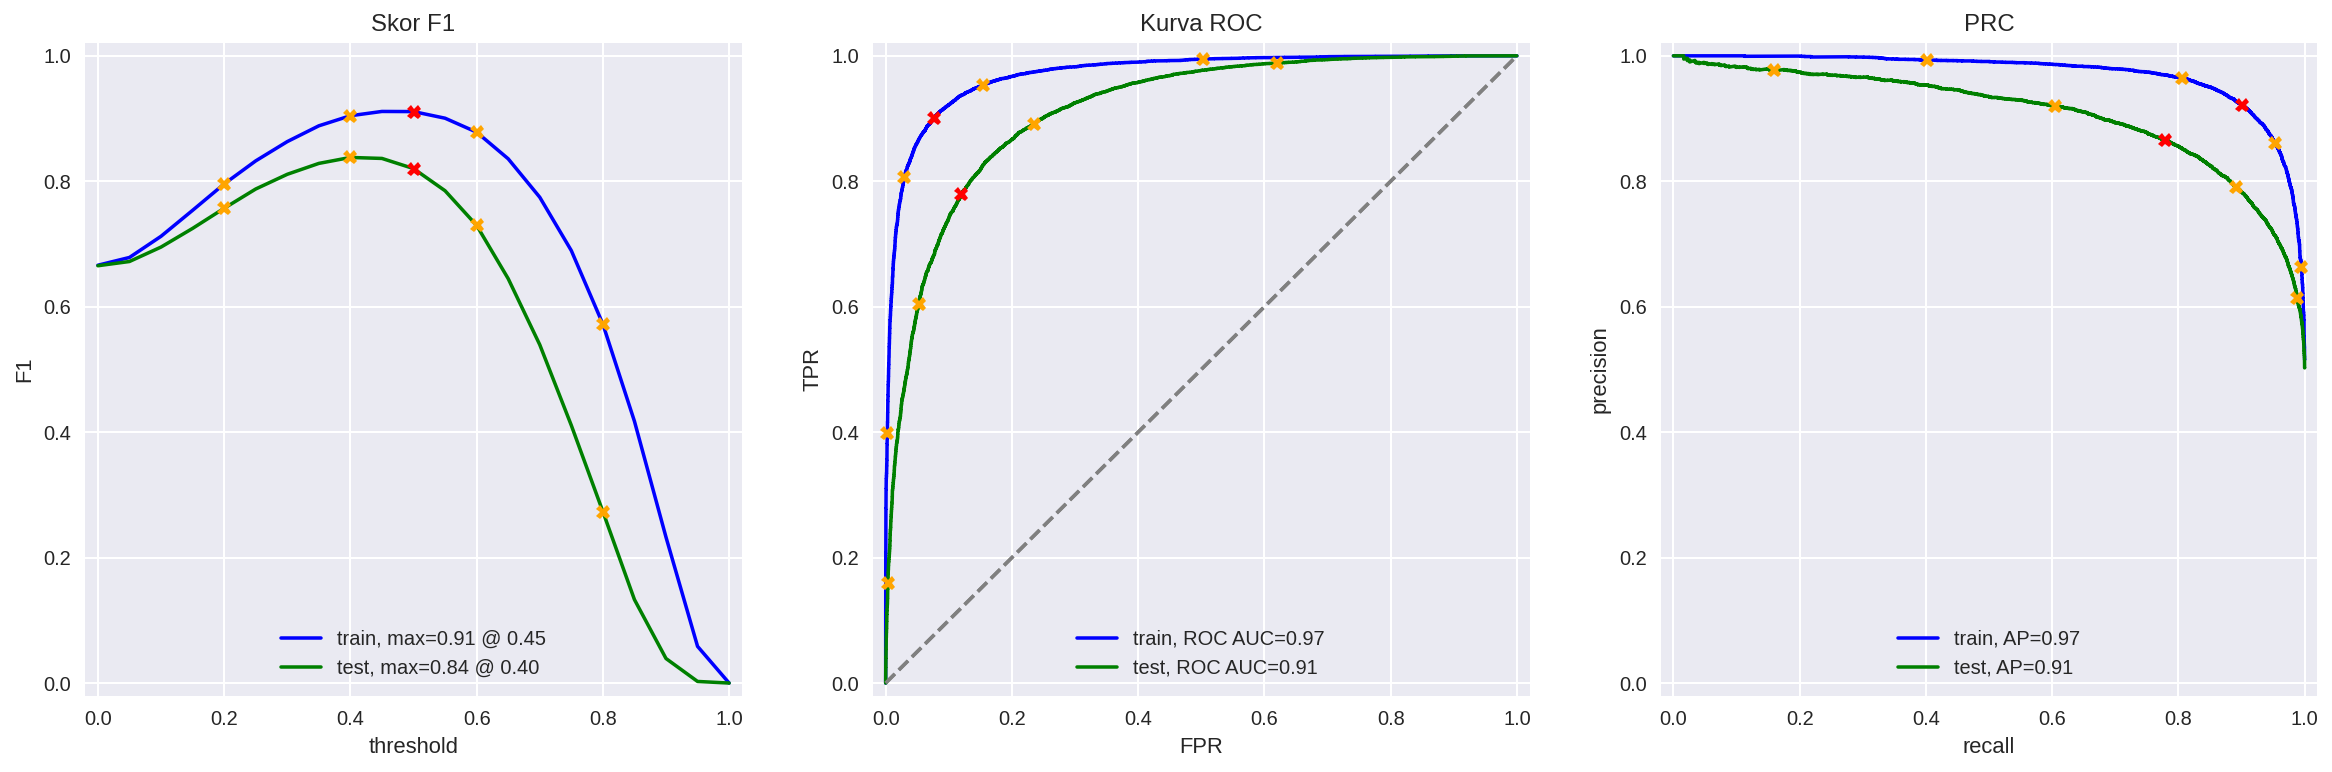

time: 1.4 s (started: 2023-08-06 16:23:53 +00:00)


In [30]:
evaluate_model(gnb, nltk_X_train, y_train, nltk_X_test, y_test)

#### LightGBM Classifier

In [31]:
from lightgbm import LGBMClassifier

time: 25.9 ms (started: 2023-08-06 16:23:55 +00:00)


In [32]:
%%time 

lgb = LGBMClassifier(random_state=12345)
lgb.fit(nltk_X_train, y_train)
lgb_tf_idf_pred = lgb.predict(nltk_X_test)

CPU times: user 1min 5s, sys: 377 ms, total: 1min 5s
Wall time: 1min 6s
time: 1min 6s (started: 2023-08-06 16:23:55 +00:00)


In [33]:
acc_lgb = accuracy_score(y_test, lgb_tf_idf_pred)
f1_sc_lgb  = f1_score(y_test, lgb_tf_idf_pred)

log_metrics_tf_idf["Accuracy_score"][m_idx_tf_idf["LightGBM Classifier"]] = acc_lgb
log_metrics_tf_idf["F1 Score"][m_idx_tf_idf["LightGBM Classifier"]] = f1_sc_lgb

time: 12.5 ms (started: 2023-08-06 16:25:01 +00:00)


          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


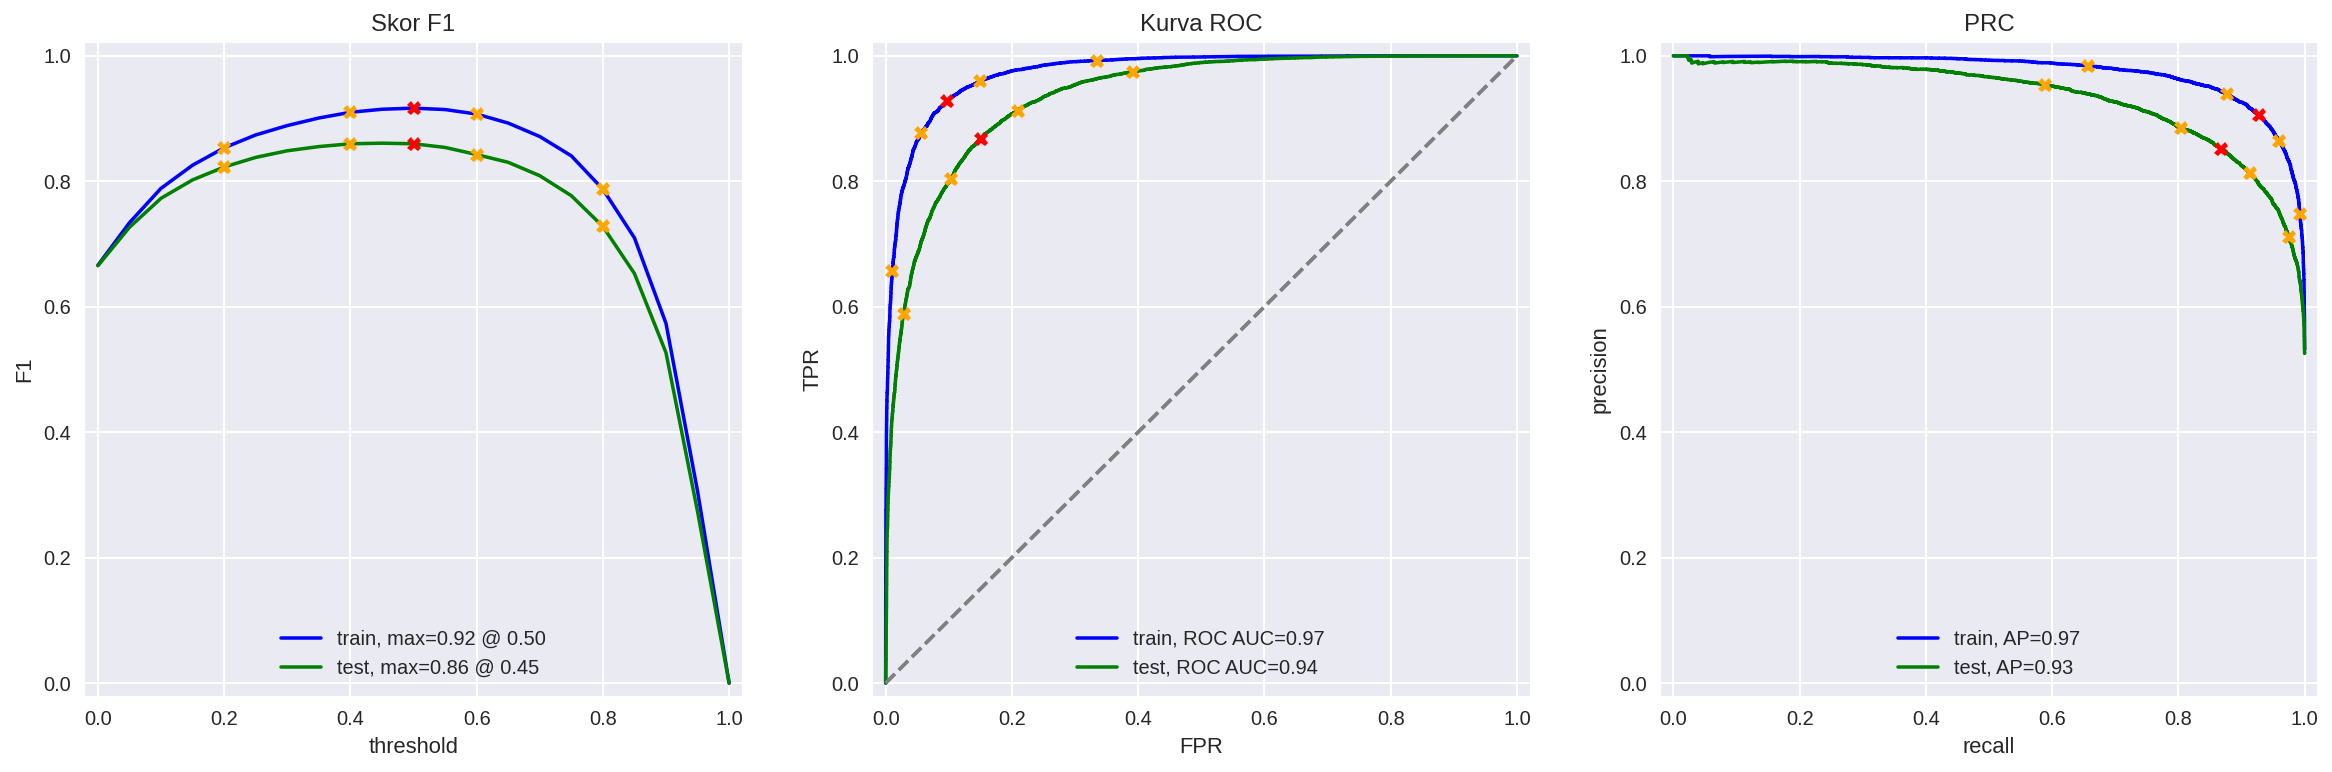

time: 2.51 s (started: 2023-08-06 16:25:01 +00:00)


In [34]:
evaluate_model(lgb, nltk_X_train, y_train, nltk_X_test, y_test)

#### Stochastic Gradient Classifier

In [35]:
from sklearn.linear_model import SGDClassifier 

time: 432 µs (started: 2023-08-06 16:25:03 +00:00)


In [36]:
%%time

sgd = SGDClassifier(random_state=12345, loss='log')
sgd.fit(nltk_X_train, y_train)
sgd_tf_idf_pred = sgd.predict(nltk_X_test)

CPU times: user 203 ms, sys: 128 ms, total: 331 ms
Wall time: 334 ms
time: 354 ms (started: 2023-08-06 16:25:03 +00:00)


In [37]:
acc_sgd = accuracy_score(y_test, sgd_tf_idf_pred)
f1_sc_sgd  = f1_score(y_test, sgd_tf_idf_pred)

log_metrics_tf_idf["Accuracy_score"][m_idx_tf_idf["Stochastic Gradient Classifier"]] = acc_sgd
log_metrics_tf_idf["F1 Score"][m_idx_tf_idf["Stochastic Gradient Classifier"]] = f1_sc_sgd

time: 12.9 ms (started: 2023-08-06 16:25:04 +00:00)


          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


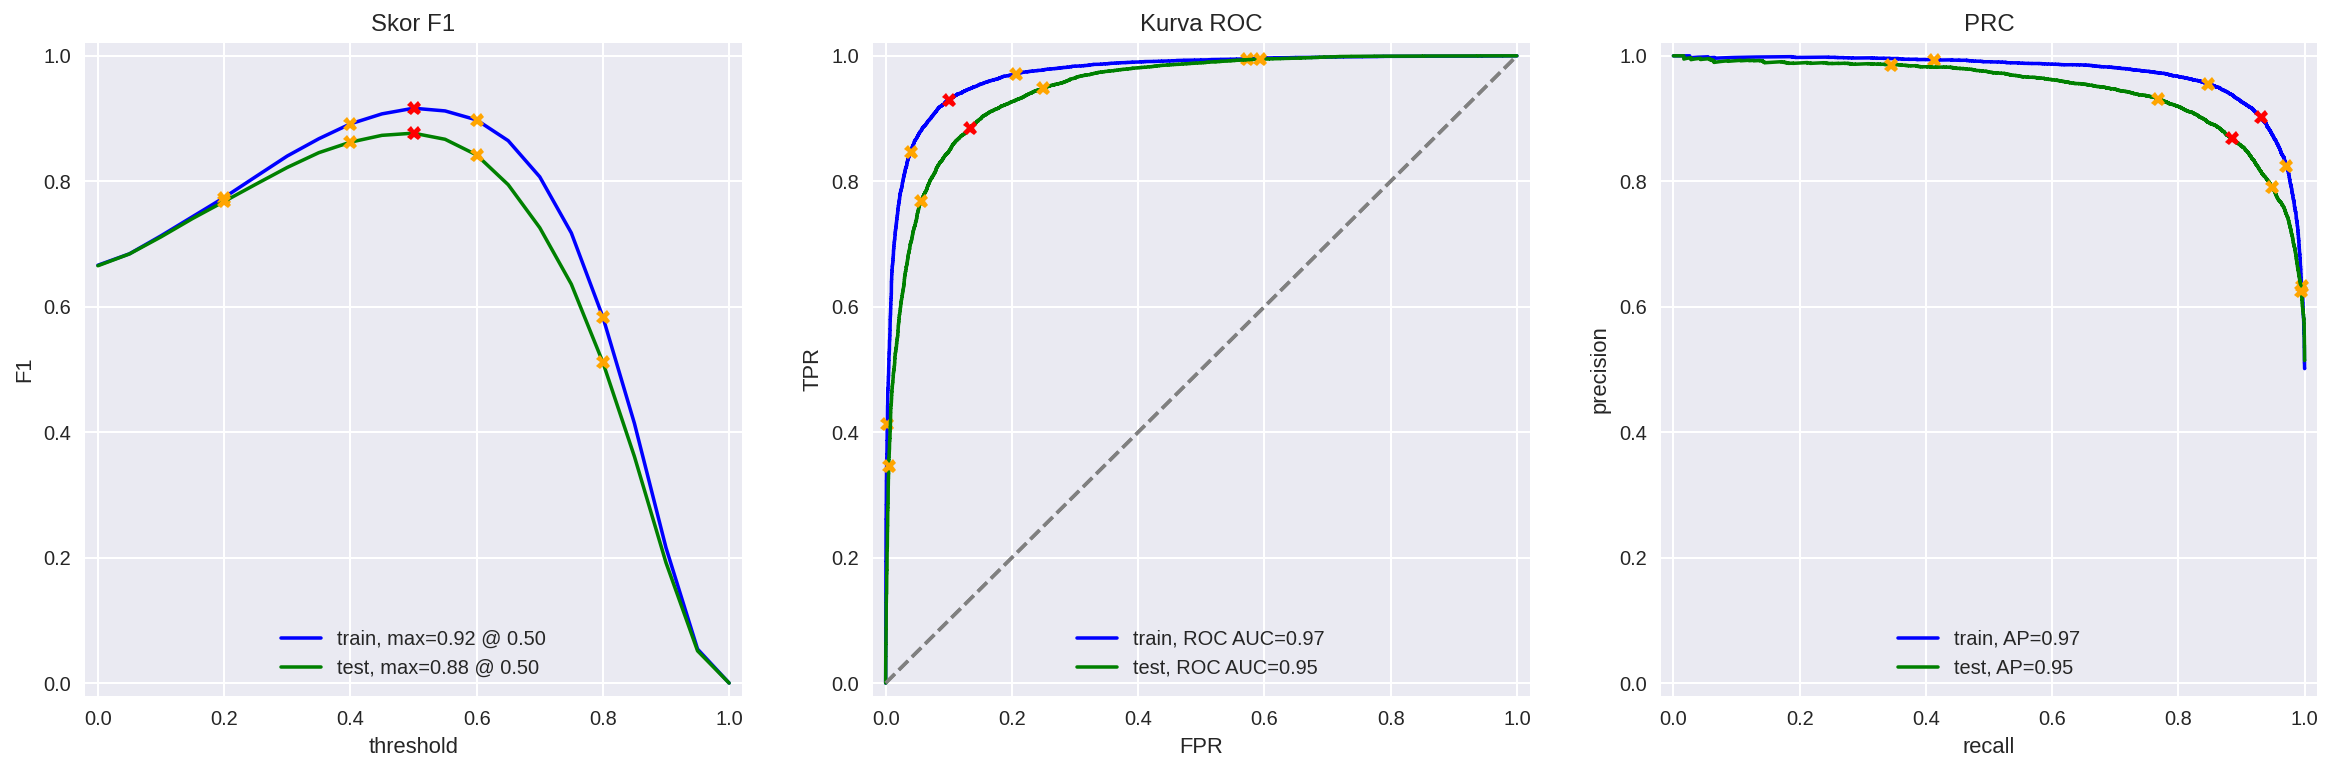

time: 1.34 s (started: 2023-08-06 16:25:04 +00:00)


In [38]:
evaluate_model(sgd, nltk_X_train, y_train, nltk_X_test, y_test)

### Model 2 - Menggunakan spaCy & TF-IDF 

Pada tahap ini kita akan menggunakan NLP Natural Languange Preprocessing dengan Proses ini membantu mempermudah penanganan teks karena variasi bentuk kata yang tersedia menjadi lebih sedikit.

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
# text pre-processing dengan spaCy
def lemmatize_spacy(text):
    doc = nlp(text.lower())
    lemmas = []
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    lemmas = [token.lemma_ for token in doc]
    lemmatize_spacy = " ".join(lemmas)
    return lemmatize_spacy

#### Menjalankan fungsi token dan lemmatiz pada train & test sampel spaCy

In [ ]:
# menjalankan fungsi token dan lemmatiz  pada train & test sampel spaCy
df_reviews_train['review_spacy'] = X_train.apply(lemmatize_spacy)
df_reviews_test['review_spacy'] = X_test.apply(lemmatize_spacy)

# menjalankan TF-IDF pada train & test sampel
spacy_X_train = count_tf_idf.fit_transform(df_reviews_train['review_spacy'])
spacy_X_test = count_tf_idf.transform(df_reviews_test['review_spacy'])

#### Data Frame hasil Model dengan spaCy & TF-IDF

In [ ]:
# Data Frame hasil Model dengan spaCy & TF-IDF 
log_metrics_spacy = {"Models": ["Logistic Regression Classifier", "Gaussian Naive Bayes", "LightGBM Classifier" ,"Stochastic Gradient Classifier" ], "Accuracy_score": [0.0]*4, "F1 Score": [0.0]*4}
m_idx_spacy = {"Logistic Regression Classifier":0, "Gaussian Naive Bayes":1, "LightGBM Classifier":2, "Stochastic Gradient Classifier" :3}

#### Logistic Regression 

In [ ]:
%%time

lr_spacy = LogisticRegression(random_state=12345, solver='liblinear')
lr_spacy.fit(spacy_X_train, y_train)
lr_spacy_pred = lr_spacy.predict(spacy_X_test)

In [ ]:
acc_lr_spacy = accuracy_score(y_test, lr_spacy_pred )
f1_sc_lr_spacy  = f1_score(y_test, lr_spacy_pred )

log_metrics_spacy["Accuracy_score"][m_idx_spacy["Logistic Regression Classifier"]] = acc_lr_spacy
log_metrics_spacy["F1 Score"][m_idx_spacy["Logistic Regression Classifier"]] = f1_sc_lr_spacy

In [ ]:
evaluate_model(lr_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

#### Gusion naïve Bayes Classifier

In [ ]:
%%time
gnb_spacy = MultinomialNB()
gnb_spacy.fit(spacy_X_train, y_train)
gnb_spacy_pred = gnb_spacy.predict(spacy_X_test)


In [ ]:
acc_gnb_spacy = accuracy_score(y_test, gnb_spacy_pred)
f1_sc_gnb_spacy = f1_score(y_test, gnb_spacy_pred)

log_metrics_spacy["Accuracy_score"][m_idx_spacy["Gaussian Naive Bayes"]] = acc_gnb_spacy
log_metrics_spacy["F1 Score"][m_idx_spacy["Gaussian Naive Bayes"]] = f1_sc_gnb_spacy

In [ ]:
evaluate_model(gnb_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

#### LightGBM Classifier

In [ ]:
%%time 

lgb_spacy = LGBMClassifier(random_state=12345)
lgb_spacy.fit(spacy_X_train, y_train)
lgb_spacy_pred = lgb_spacy.predict(spacy_X_test)

In [ ]:
acc_lgb_spacy = accuracy_score(y_test, lgb_spacy_pred)
f1_sc_lgb_spacy = f1_score(y_test, lgb_spacy_pred)

log_metrics_spacy["Accuracy_score"][m_idx_spacy["LightGBM Classifier"]] = acc_lgb_spacy
log_metrics_spacy["F1 Score"][m_idx_spacy["LightGBM Classifier"]] = f1_sc_lgb_spacy

In [ ]:
evaluate_model(lgb_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

#### Stochastic Gradient Classifier

In [ ]:
%%time

sgd_spacy = SGDClassifier(random_state=12345, loss='log')
sgd_spacy.fit(spacy_X_train, y_train)
sgd_spacy_pred = sgd_spacy.predict(spacy_X_test)

In [ ]:
acc_sgd_spacy = accuracy_score(y_test, sgd_spacy_pred)
f1_sc_sgd_spacy  = f1_score(y_test, sgd_spacy_pred)

log_metrics_spacy["Accuracy_score"][m_idx_spacy["Stochastic Gradient Classifier"]] = acc_sgd_spacy
log_metrics_spacy["F1 Score"][m_idx_spacy["Stochastic Gradient Classifier"]] = f1_sc_sgd_spacy

In [ ]:
evaluate_model(sgd_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

###  Model 3 - Menggunakan BERT

Pada tahap ini kita akan mengubah teks ke vektor menggunakan BERT (Bidirectional Encoder Representations from Transformers) adalah jaringan neural (neural network) yang dibuat untuk merepresentasikan bahasa yakni model Deep Learning untuk NLP yang didasarkan pada Transformer di mana setiap elemen output terhubung ke setiap elemen input, dan bobot elemen dihitung secara dinamis berdasarkan hubungan antar elemen.

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# maximum sample size
max_sample_size = 500

In [ ]:
# Fungsi untuk menjalankan bert
def BERT_text_to_embeddings(texts, max_length=512, batch_size=25, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    max_sample_size = 500
    
    # teks ke id token yang sudah di-padded bersamaan dengan attention mask
    for input_text in texts.iloc[:max_sample_size]['review']:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Gunakan {device} perangkat.')
      
    # dapatkan embedding dalam batch 
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <masukkan kode di sini untuk membuat attention_mask_batch 
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
           
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

#### Menjalankan fungsi token dan BERT Text Embedding ke Train & Test sample

In [ ]:
%%time

# Perhatian! Menjalankan BERT untuk ribuan teks mungkin memakan waktu lama di CPU, setidaknya beberapa jam
bert_X_train = BERT_text_to_embeddings(df_reviews_train, force_device='cpu')
bert_y_train = df_reviews_train.iloc[:max_sample_size]['pos']

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(bert_X_train.shape)
print(bert_y_train.shape)

In [ ]:
%%time

# Perhatian! Menjalankan BERT untuk ribuan teks mungkin memakan waktu lama di CPU, setidaknya beberapa jam
bert_X_test = BERT_text_to_embeddings(df_reviews_test, force_device='cpu')
bert_y_test = df_reviews_test.iloc[:max_sample_size]['pos']

In [ ]:
print(df_reviews_test['review_norm'].shape)
print(bert_X_test.shape)
print(bert_y_test.shape)

In [ ]:
# normalisasi feature untuk menghindari nilai error
scaler = MinMaxScaler()
scaler.fit(bert_X_train)

# merubah train dan test dataset menggunakan transform dari scaler
bert_X_train = scaler.transform(bert_X_train)
bert_X_test = scaler.transform(bert_X_test)

#### Data Frame hasil Model dengan BERT

In [ ]:
# Data Frame hasil Model dengan BERT
log_metrics_bert = {"Models": ["Logistic Regression Classifier", "Gaussian Naive Bayes", "LightGBM Classifier" ,"Stochastic Gradient Classifier" ], "Accuracy_score": [0.0]*4, "F1 Score": [0.0]*4}
m_idx_bert = {"Logistic Regression Classifier":0, "Gaussian Naive Bayes":1, "LightGBM Classifier":2, "Stochastic Gradient Classifier" :3}

#### Logistic Regression 

In [ ]:
%%time

lr_bert = LogisticRegression(random_state=12345, solver='liblinear')
lr_bert.fit(bert_X_train, bert_y_train)
lr_bert_pred = lr_bert.predict(bert_X_test)

In [ ]:
acc_lr_bert = accuracy_score(bert_y_test, lr_bert_pred )
f1_sc_lr_bert = f1_score(bert_y_test, lr_bert_pred )

In [ ]:
log_metrics_bert["Accuracy_score"][m_idx_bert["Logistic Regression Classifier"]] = acc_lr_bert
log_metrics_bert["F1 Score"][m_idx_bert["Logistic Regression Classifier"]] = f1_sc_lr_bert

In [ ]:
evaluate_model(lr_bert, bert_X_train, bert_y_train, bert_X_test, bert_y_test)

#### Gusion naïve Bayes Classifier

In [ ]:
%%time
gnb_bert = MultinomialNB()
gnb_bert.fit(bert_X_train, bert_y_train)
gnb_bert_pred = gnb_bert.predict(bert_X_test)

In [ ]:
acc_gnb_bert = accuracy_score(bert_y_test, gnb_bert_pred)
f1_sc_gnb_bert = f1_score(bert_y_test, gnb_bert_pred)

log_metrics_bert["Accuracy_score"][m_idx_bert["Gaussian Naive Bayes"]] = acc_gnb_bert
log_metrics_bert["F1 Score"][m_idx_bert["Gaussian Naive Bayes"]] = f1_sc_gnb_bert

In [ ]:
evaluate_model(gnb_bert, bert_X_train, bert_y_train, bert_X_test, bert_y_test)

#### LightGBM Classifier

In [ ]:
%%time 

lgb_bert = LGBMClassifier(random_state=12345)
lgb_bert.fit(bert_X_train, bert_y_train)
lgb_bert_pred = lgb_bert.predict(bert_X_test)

In [ ]:
acc_lgb_bert = accuracy_score(bert_y_test, lgb_bert_pred)
f1_sc_lgb_bert = f1_score(bert_y_test, lgb_bert_pred)

log_metrics_bert["Accuracy_score"][m_idx_bert["LightGBM Classifier"]] = acc_lgb_bert
log_metrics_bert["F1 Score"][m_idx_bert["LightGBM Classifier"]] = f1_sc_lgb_bert

In [ ]:
evaluate_model(lgb_bert, bert_X_train, bert_y_train, bert_X_test, bert_y_test)

#### Stochastic Gradient Classifier

In [ ]:
%%time

sgd_bert = SGDClassifier(random_state=12345, loss='log')
sgd_bert.fit(bert_X_train, bert_y_train)
sgd_bert_pred = sgd_bert.predict(bert_X_test)

In [ ]:
acc_sgd_bert = accuracy_score(bert_y_test, sgd_bert_pred)
f1_sc_sgd_bert = f1_score(bert_y_test, sgd_bert_pred)

log_metrics_bert["Accuracy_score"][m_idx_bert["Stochastic Gradient Classifier"]] = acc_sgd_bert
log_metrics_bert["F1 Score"][m_idx_bert["Stochastic Gradient Classifier"]] = f1_sc_sgd_bert

In [ ]:
evaluate_model(sgd_bert, bert_X_train, bert_y_train, bert_X_test, bert_y_test)

## Hasil Model 1, 2 & 3

#### Hasil Model Dengan TF-IDF

In [ ]:
pd.DataFrame(log_metrics_tf_idf).sort_values("Accuracy_score", ascending=False).reset_index(drop='index')

#### Hasil Model Dengan spaCy

In [ ]:
pd.DataFrame(log_metrics_spacy).sort_values("Accuracy_score", ascending=False).reset_index(drop='index')

#### Hasil Model Dengan BERT

In [ ]:
pd.DataFrame(log_metrics_bert).sort_values("Accuracy_score", ascending=False).reset_index(drop='index')

Kesimpulan : 
-----------------------

Pada hasil model menggunakan Natural Languange Preprocessing dari TF-IDF, spaCy dan BERT model `Logistic Regression Classifier` memiliki Accuracy dan F1 Score yang tinggi yakni 1. `Accuracy Score : 0.879796 dan F1 Score 0.879376` pada NLP `TF-IDF` lalu 2. `Accuracy Score : 0.878691 dan F1 Score 0.878753` pada NLP `spaCy` dan 3. `Accuracy Score : 0.814 dan F1 Score 0.826168` pada NLP `BERT`. pada tahp selanjutnya kita akan menggunakan model ML dengan NLP TF-IDF untuk memprediksi ulasan dengan model ML yang telah kita latih. 

## Ulasan Saya

In [ ]:
my_reviews = pd.DataFrame([
    'saya tidak begitu menyukainya, bukan jenis film kesukaan saya.', 
    'Membosankan, bahkan saya tidur di tengah-tengah film.', 
    'Filmnya sangat bagus, saya sangat suka',     
    'Bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya, apakah mereka dibayar untuk bermain film. Sungguh tidak bermutu.', 
    'Saya tidak menyangka filmnya sebagus ini! Para penulis sungguh memperhatikan tiap detailnya', 
    'Film ini memiliki kelebihan dan kekurangan, tetapi saya merasa secara keseluruhan ini adalah film yang layak. Saya mungkin akan menontonnya lagi.', 
    'Beberapa lawakannya sungguh tidak lucu. Tidak ada satu pun lelucon yang berhasil, semua orang bertingkah menyebalkan, bahkan anak-anak pun tidak akan menyukai ini!', 
    'Menayangkan film ini di Netflix adalah langkah yang berani & saya sangat senang bisa menonton episode demi episode dari drama baru yang menarik dan cerdas ini.' 
], columns=['review'])

In [ ]:
# jangan ragu untuk menghapus ulasan ini dan mencoba model Anda sendiri terhadap ulasan Anda, ini hanyalah sekadar contoh 

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])
# clean reviews
my_reviews['review_norm'] = my_reviews['review'].apply(clean_data)# <masukkan logika normalisasi yang sama di sini sebagaimana pada dataset utama>
my_reviews

In [ ]:
# clean dataset untuk di prediksi
texts = my_reviews['review_norm']

### Model 1

In [ ]:
# membuat prediksi logistic regression classifier
lr_pred = lr.predict(count_tf_idf.transform(texts))
lr_pred_prob = lr.predict_proba(count_tf_idf.transform(texts))[:, 1]

# ringkasan hasil prediksi
print(f'{sum(lr_pred)} Ulasan diprediksi dengan komentar positive dari {len(lr_pred_prob)} ulasan')
print('='*50)
print()
print('Pos:'+'  '+'Proba:'+'  '+'Actual Ulasan')
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'  {lr_pred[i]}:   {lr_pred_prob[i]:.2f}:  {review}')

### Model 2

In [ ]:
# Gusion naïve Bayes Classifier
gnb_pred = gnb.predict(count_tf_idf.transform(texts))
gnb_pred_prob = gnb.predict_proba(count_tf_idf.transform(texts))[:, 1]

# ringkasan hasil prediksi
print(f'{sum(gnb_pred)} Ulasan diprediksi dengan komentar positive dari {len(gnb_pred_prob)} ulasan')
print('='*50)
print()
print('Pos:'+'  '+'Proba:'+'  '+'Actual Ulasan')
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'  {lr_pred[i]}:   {lr_pred_prob[i]:.2f}:  {review}')

### Model 3

In [ ]:
# LightGBM Classifier
lgbm_pred = lgb.predict(count_tf_idf.transform(texts))
lgbm_pred_prob = lgb.predict_proba(count_tf_idf.transform(texts))[:, 1]

# ringkasan hasil prediksi
print(f'{sum(lgbm_pred)} Ulasan diprediksi dengan komentar positive dari {len(lgbm_pred_prob)} ulasan')
print('='*50)
print()
print('Pos:'+'  '+'Proba:'+'  '+'Actual Ulasan')
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'  {lr_pred[i]}:   {lr_pred_prob[i]:.2f}:  {review}')

### Model 4

In [ ]:
# Stochastic Gradient Classifier
sgd_pred = sgd.predict(count_tf_idf.transform(texts))
sgd_pred_prob = sgd.predict_proba(count_tf_idf.transform(texts))[:, 1]

# ringkasan hasil prediksi
print(f'{sum(sgd_pred)} Ulasan diprediksi dengan komentar positive dari {len(sgd_pred_prob)} ulasan')
print('='*50)
print()
print('Pos:'+'  '+'Proba:'+'  '+'Actual Ulasan')
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'  {lr_pred[i]}:   {lr_pred_prob[i]:.2f}:  {review}')

Kesimpulan :
----
Dari dataset sebanyak 8 ulasan, didapati prediksi dengan 4 ulasan positif dan 4 ulasan negatif. Dari hasil prediksi model yang telah dilatih :
1. Logistik Regresi memprediksi 4 ulasan positif dan 4 ulasan negatif.
2. Gusion naïve Bayes Classifier memprediksi 3 ulasan positif dan 5 ulasan negatif.
3. LightGBM Classifier memprediksi 8 ulasan positif dan 0 ulasan negatif.
4. Stochastic Gradient Classifier memprediksi 6 ulasan positif dan 2 ulasan negatif.

Dari hasil model dengan performa yang terbaik untuk membantu memprediksi ulasan film dari Junky Union adalah Logistik Regresi.

# Daftar Periksa

- [x]  *Notebook* dibuka 
- [ ]  Data teks telah dimuat dan dilakukan pra-pemrosesan untuk vektorisasi 
- [ ]  Data teks telah diubah menjadi vektor 
- [ ]  Model telah terlatih dan diuji 
- [ ]  Ambang batas metrik tercapai 
- [ ]  Semua kode sel tersusun sesuai urutan eksekusinya 
- [ ]  Semua kode sel bisa dieksekusi tanpa *error* 
- [ ]  Terdapat kesimpulan 